# Training of Fully Convolutional Network

The aim of this notebook is to train..................

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# Import python libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import utilitary functions and module defining the Unet model.
#from utils import get_dataset_from_folders
from scripts.data_generator import DataGenerator
from scripts.model import fully_convolutional_network
from scripts.plots import plot_history

In [2]:
# Set seeds of random number generators to guarantee reproducibility.
#np.random.seed(1)
#tensorflow.random.set_seed(2)

### $\bullet$ Setting different paths

In [3]:
# Variable defining where to save the dataset locally, relative to "~/.keras/datasets"
mnist_path   = os.path.join(os.getcwd(), "Dataset", "Mnist"  , "mnist.npz")
figures_path = os.path.join(os.getcwd(), "Dataset", "Figures", "figures.npz")

# Variable defining where models will be stored.
model_save_path = os.path.join(os.getcwd(), "Models", "Fully Connected Network")

### $\bullet$ Load images from the dataset

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_train_val_test_data(mnist_path, figures_path, batch_size, val_split = 0.3, resolution = (28, 28)):
    # Load data from Mnist.
    (mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data(path = mnist_path)
    
    # Load figures and figures labels.
    figures_loaded_file = np.load(figures_path)
    figures_images = figures_loaded_file['figures']
    figures_labels  = figures_loaded_file['labels']
    
    # Train-Validation Split of Mnist ensuring label balance.
    train_idx, val_idx = next(StratifiedShuffleSplit(n_splits = 1, test_size = val_split).split(mnist_train_images, mnist_train_labels))
    mnist_val_images = mnist_train_images[val_idx]
    mnist_val_labels = mnist_train_labels[val_idx]
    mnist_train_images = mnist_train_images[train_idx]
    mnist_train_labels = mnist_train_labels[train_idx]
    
    print(f'Training set contains {len(mnist_train_images)} images.')
    print(f'Validation set contains {len(mnist_val_images)} images.')
    print(f'Test set contains {len(mnist_test_images)} images.')
    
    # Creating Train, Validation and Test generators.
    train_generator = DataGenerator(mnist_train_images, mnist_train_labels, figures_images, figures_labels, 
                                    resolution, batch_size)
    val_generator   = DataGenerator(mnist_val_images  , mnist_val_labels  , figures_images, figures_labels, 
                                    resolution, batch_size)
    test_generator  = DataGenerator(mnist_test_images , mnist_test_labels , figures_images, figures_labels, 
                                    resolution, batch_size)
    
    return train_generator, val_generator, test_generator

batch_size = 130
train_generator, val_generator, test_generator = get_train_val_test_data(mnist_path, figures_path, batch_size = batch_size)

Training set contains 42000 images.
Validation set contains 18000 images.
Test set contains 10000 images.


### $\bullet$ Training Fully Convolutional Model using Data Augmentation

In [5]:
def crossentropy(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, tf.squeeze(y_pred))
    

def accuracy(y_true, y_pred):
    return tf.keras.metrics.categorical_accuracy(y_true, tf.squeeze(y_pred))
    

# Setting up parameters used for training
number_epochs = 10
early_stopping = EarlyStopping(patience = 50, verbose = 1)
model_checkpoint = ModelCheckpoint(filepath = model_save_path, save_weights_only = False, monitor = 'val_accuracy', save_best_only = True)

# Building model.
model = fully_convolutional_network(show_summary = True)

# Compiling model.
model.compile(optimizer = 'adam', loss = crossentropy, metrics = [accuracy])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 32)    320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   401536    
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, None, None, 128)   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 13)    1

In [6]:
# Training
history = model.fit(train_generator, validation_data = val_generator, epochs = number_epochs, callbacks = [early_stopping, model_checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 379 steps, validate for 162 steps
Epoch 1/10
378/379 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.9215WARNING:tensorflow:From C:\Anaconda3\envs\image_proc\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\andre\Desktop\Cours Image Processing\Project\Models\Fully Connected Network\assets
379/379 [==============================] - 9s 24ms/step - loss: 0.2627 - accuracy: 0.9216 - val_loss: 0.0662 - val_accuracy: 0.9797
Epoch 2/10
379/379 [==============================] - 7s 18ms/step - loss: 0.0884 - accuracy: 0.9747 - val_loss: 0.0451 - val_accuracy: 0.9864
Epoch 3/10
379/379 [===================

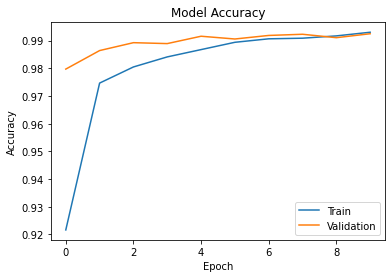

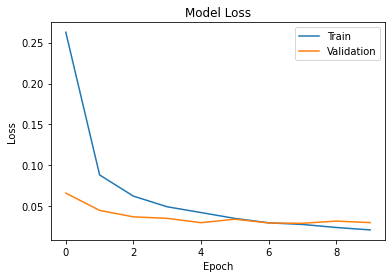

In [7]:
plot_history(history)

In [8]:
# Load best model saved by ModelCheckpoint
model = tf.keras.models.load_model(model_save_path, compile = False)
model.compile(optimizer = 'adam', loss = crossentropy, metrics = [accuracy])

# Evaluate best model
model.evaluate(test_generator);

89/89 [==============================] - 1s 7ms/step - loss: 0.0206 - accuracy: 0.9942
